In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("🔎 Western Europe Military Expenditure Analysis")
print("===============================================")

🔎 Western Europe Military Expenditure Analysis


In [2]:
# Cell 2: Data Loading Functions
def load_data():
    """Upload and load data file in Google Colab."""
    print("📤 Please upload the SIPRI-Milex-data Excel file...")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No file was uploaded.")
        return None, None

    file_name = list(uploaded.keys())[0]
    file_path = f"/content/{file_name}"

    print(f"✅ File '{file_name}' uploaded successfully!")
    return file_path, file_name

In [3]:
# Cell 3: Data Processing Functions
def process_military_data(file_path):
    """Load and process military expenditure data."""
    try:
        # Load dataset
        print("⏳ Loading data...")
        df = pd.read_excel(file_path, sheet_name="Current US$", skiprows=5, engine="openpyxl")

        # Drop Notes column if exists
        if "Notes" in df.columns:
            df = df.drop(columns=["Notes"])

        # Extract Western European countries
        western_europe_countries = [
            "Austria", "Belgium", "Denmark", "Finland", "France",
            "Germany", "Greece", "Ireland", "Italy", "Luxembourg",
            "Netherlands", "Norway", "Portugal", "Spain", "Sweden",
            "Switzerland", "United Kingdom"
        ]

        # Try country list approach first
        western_europe_df = df[df.iloc[:, 0].isin(western_europe_countries)].copy()

        # If insufficient matches, fall back to index approach
        if len(western_europe_df) < 10:
            print("ℹ️ Using index-based approach for country selection.")
            try:
                austria_index = df[df.iloc[:, 0] == "Austria"].index[0]
                uk_index = df[df.iloc[:, 0] == "United Kingdom"].index[0]
                western_europe_df = df.iloc[austria_index:uk_index + 1, :].copy()
            except IndexError:
                print("⚠️ Warning: Could not find Austria or UK in dataset.")
                return None

        # Reset index
        western_europe_df = western_europe_df.reset_index(drop=True)

        # Set correct column names
        year_columns = list(range(1993, 2024))  # Years from 1993 to 2023
        column_names = ["Country"] + year_columns
        western_europe_df.columns = column_names[:western_europe_df.shape[1]]

        # Convert to numeric and round
        for year in year_columns:
            if year in western_europe_df.columns:
                western_europe_df.loc[:, year] = pd.to_numeric(western_europe_df[year], errors='coerce').round(1)

        print(f"✅ Successfully processed data for {len(western_europe_df)} Western European countries")
        return western_europe_df

    except Exception as e:
        print(f"❌ Error processing data: {e}")
        return None

In [4]:
# Cell 4: Data Quality Check Functions
def check_data_quality(df):
    """Perform data quality checks and return results."""
    print("\n📊 Performing data quality checks...")

    duplicate_rows = df.duplicated().sum()
    duplicate_countries = df["Country"].duplicated().sum()
    missing_values_per_column = df.isnull().sum()
    missing_values_total = df.isnull().sum().sum()
    empty_rows = df.isnull().all(axis=1).sum()
    empty_columns = df.isnull().all(axis=0).sum()

    # Calculate completeness percentage
    total_cells = df.shape[0] * df.shape[1]
    data_completeness = ((total_cells - missing_values_total) / total_cells) * 100

    # Get summary statistics
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    summary_statistics = df[numeric_cols].describe().round(1)

    quality_checks = {
        "Total Rows": len(df),
        "Total Columns": len(df.columns),
        "Year Range": f"{df.columns[1]} to {df.columns[-1]}",
        "Total Duplicate Rows": duplicate_rows,
        "Total Duplicate Countries": duplicate_countries,
        "Total Missing Values": missing_values_total,
        "Total Completely Empty Rows": empty_rows,
        "Total Completely Empty Columns": empty_columns,
        "Data Completeness": f"{data_completeness:.2f}%"
    }

    # Print data quality results
    print("\n📌 Data Quality Report:")
    for key, value in quality_checks.items():
        print(f"{key}: {value}")

    # Check for critical issues
    has_critical_issues = duplicate_rows > 0 or empty_rows > 0 or empty_columns > 0

    return quality_checks, summary_statistics, has_critical_issues

def save_processed_data(df, prefix="western_europe_military_expenditure"):
    """Save the processed dataset to CSV."""
    try:
        cleaned_file_path = f"/content/{prefix}_clean.csv"
        df.to_csv(cleaned_file_path, index=False)
        print(f"\n✅ Cleaned dataset saved at: {cleaned_file_path}")

        # Download the file
        files.download(cleaned_file_path)
        print("📥 Download initiated!")

        return cleaned_file_path
    except Exception as e:
        print(f"❌ Error saving data: {e}")
        return None

In [5]:
# Cell 5: Visualization Functions
def plot_spending_trends(df, selected_countries=None, year_range=None):
    """Plot military spending trends for selected countries."""
    if selected_countries is None:
        # Default to top 5 countries by 2023 spending
        latest_year = df.columns[-1]
        selected_countries = df.nlargest(5, latest_year)["Country"].tolist()

    # Filter the dataset for selected countries
    filtered_df = df[df["Country"].isin(selected_countries)].copy()

    # Determine year range to plot
    if year_range is None:
        year_columns = [col for col in df.columns if isinstance(col, int)]
    else:
        year_columns = [col for col in df.columns if isinstance(col, int) and col >= year_range[0] and col <= year_range[1]]

    # Set up the figure
    plt.figure(figsize=(14, 8))

    # Plot the trends with thicker lines and markers
    for country in selected_countries:
        country_data = filtered_df[filtered_df["Country"] == country].iloc[:, 1:].values.flatten()
        plt.plot(year_columns, country_data[:len(year_columns)], marker='o', linewidth=2, markersize=5, label=country)

    # Customize the chart
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Military Expenditure (Million USD)", fontsize=12)
    plt.title("Military Spending Trends", fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

    # Add annotations for notable events
    plt.axvline(x=2001, color='gray', linestyle='--', alpha=0.7)
    plt.text(2001, plt.ylim()[1]*0.95, "9/11", rotation=90, verticalalignment='top')

    plt.axvline(x=2008, color='gray', linestyle='--', alpha=0.7)
    plt.text(2008, plt.ylim()[1]*0.95, "Financial Crisis", rotation=90, verticalalignment='top')

    plt.axvline(x=2014, color='gray', linestyle='--', alpha=0.7)
    plt.text(2014, plt.ylim()[1]*0.95, "Crimea Crisis", rotation=90, verticalalignment='top')

    plt.axvline(x=2020, color='gray', linestyle='--', alpha=0.7)
    plt.text(2020, plt.ylim()[1]*0.95, "COVID-19", rotation=90, verticalalignment='top')

    plt.tight_layout()
    plt.show()

def plot_current_spending(df, year=None):
    """Plot bar chart of military spending for a specific year."""
    if year is None:
        year = df.columns[-1]  # Use the latest year available

    # Sort countries by spending
    sorted_df = df.sort_values(by=year, ascending=False).copy()

    # Set up the figure with more width
    plt.figure(figsize=(15, 10))  # Increased width from 14 to 15

    # Create a colormap
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(sorted_df)))

    # Plot bar chart
    bars = plt.barh(sorted_df["Country"], sorted_df[year], color=colors)

    # Calculate maximum value for scaling
    max_value = sorted_df[year].max()

    # Add data labels
    for bar in bars:
        width = bar.get_width()
        # For larger bars (>25% of max), place text inside the bar
        if width > (max_value * 0.25):
            plt.text(width * 0.95, bar.get_y() + bar.get_height()/2, f'{width:,.1f}',
                    va='center', ha='right', fontsize=9, color='white', fontweight='bold')
        else:
            # For smaller bars, place text outside with consistent padding
            plt.text(width + (max_value * 0.02), bar.get_y() + bar.get_height()/2, f'{width:,.1f}',
                    va='center', ha='left', fontsize=9)

    # Extend the x-axis limit to accommodate the labels
    plt.xlim(0, max_value * 1.2)  # Add 20% padding to the right

    # Remove top and right spines for cleaner look
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Customize the chart
    plt.xlabel("Military Expenditure (Million USD)", fontsize=12)
    plt.ylabel("Country", fontsize=12)
    plt.title(f"Military Spending by Country in {year}", fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()  # Invert to show highest spender at the top
    plt.grid(True, axis='x', alpha=0.3)

    # Add padding to the right side of the plot
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # Increased right margin from 0.9 to 0.85

    plt.show()

def plot_spending_heatmap(df):
    """Create a heatmap of military spending across years."""
    # Prepare data: transpose to get years as rows and countries as columns
    heatmap_data = df.set_index('Country').T

    # Calculate percentage change year over year
    pct_change = heatmap_data.pct_change() * 100

    # Set up the figure
    plt.figure(figsize=(16, 10))
    sns.heatmap(pct_change, cmap="RdBu_r", center=0, vmin=-20, vmax=20,
                annot=False, linewidths=0.5, cbar_kws={'label': 'Year-over-Year % Change'})

    # Customize the chart
    plt.title("Military Spending Year-over-Year % Change", fontsize=16, fontweight='bold')
    plt.xlabel("Country", fontsize=12)
    plt.ylabel("Year", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [6]:
# Cell 6: Additional Analysis Functions
def calculate_additional_metrics(df):
    """Calculate additional metrics for analysis."""
    # Create a copy to avoid modifying the original DataFrame
    analysis_df = df.copy()

    # Get the latest available year
    latest_year = df.columns[-1]

    # Calculate CAGR (Compound Annual Growth Rate) over the last 10 years
    ten_years_ago = latest_year - 10
    if ten_years_ago in df.columns:
        analysis_df['10Y_CAGR'] = ((df[latest_year] / df[ten_years_ago]) ** (1/10) - 1) * 100

    # Calculate average annual spending in the last 5 years
    last_5_years = [year for year in df.columns if isinstance(year, int) and year >= latest_year - 4]
    if len(last_5_years) > 0:
        analysis_df['5Y_Avg'] = df[last_5_years].mean(axis=1)

    # Calculate spending volatility (standard deviation of annual % changes)
    year_columns = [col for col in df.columns if isinstance(col, int)]
    pct_changes = df[year_columns].pct_change(axis=1)
    analysis_df['Volatility'] = pct_changes.std(axis=1) * 100

    # Get top 5 countries by latest spending
    top_countries = analysis_df.nlargest(5, latest_year)

    # Print additional metrics
    print("\n📈 Additional Metrics for Top 5 Military Spenders:")
    metrics_to_show = ['Country', latest_year, '10Y_CAGR', '5Y_Avg', 'Volatility']
    print(top_countries[metrics_to_show].round(1).to_string(index=False))

    return analysis_df


In [7]:
# Cell 7: Step 1 - Data Loading
# Run this cell to upload your file
file_path, file_name = load_data()

📤 Please upload the SIPRI-Milex-data Excel file...


Saving SIPRI-Milex-data-1993-2024.xlsx to SIPRI-Milex-data-1993-2024.xlsx
✅ File 'SIPRI-Milex-data-1993-2024.xlsx' uploaded successfully!


In [8]:
# Cell 8: Step 2 - Data Processing
# Run this cell to process the data
if 'file_path' in locals() and file_path is not None:
    df = process_military_data(file_path)
    # Display the first few rows of the processed data
    if df is not None:
        print("\nPreview of processed data:")
        display(df.head())
else:
    print("⚠️ Please run the previous cell to upload a file first.")

⏳ Loading data...
✅ Successfully processed data for 17 Western European countries

Preview of processed data:


,Country,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Austria,2115.1,2227.6,2557.8,2457.9,2164.8,2159.8,2124.4,1925.6,1788.8,...,3305.2,2665.4,2885.9,3153.1,3388.0,3336.5,3840.1,4196.4,3612.7,4410.0
1,Belgium,3746.0,3944.1,4449.0,4241.9,3684.1,3664.3,3598.4,3190.8,3036.0,...,5191.5,4202.1,4255.5,4432.8,4840.1,4761.2,5317.5,6239.4,6890.2,7629.4
2,Denmark,2682.0,2718.8,3118.0,3086.2,2804.3,2846.1,2784.9,2392.5,2525.2,...,4056.9,3364.0,3592.7,3764.0,4558.7,4487.8,4887.2,5273.7,5475.0,8144.9
3,Finland,1615.4,1756.3,1909.0,2021.8,1947.0,1959.7,1653.9,1558.1,1479.3,...,3985.5,3399.1,3415.0,3431.1,3754.6,3635.2,3868.7,3831.6,4446.4,7348.0
4,France,35775.3,37288.6,40124.0,38977.7,34697.9,33633.6,32672.7,28403.1,27951.6,...,53134.8,45647.5,47370.6,49195.7,51409.8,50118.9,52747.1,56647.0,53638.7,61301.3


In [9]:
# Cell 9: Step 3 - Data Quality Checks
# Run this cell to check data quality
if 'df' in locals() and df is not None:
    quality_checks, summary_stats, has_critical_issues = check_data_quality(df)

    print("\nSummary statistics:")
    display(summary_stats)
else:
    print("⚠️ Please run the previous cells to process data first.")


📊 Performing data quality checks...

📌 Data Quality Report:
Total Rows: 17
Total Columns: 32
Year Range: 1993 to 2023
Total Duplicate Rows: 0
Total Duplicate Countries: 0
Total Missing Values: 0
Total Completely Empty Rows: 0
Total Completely Empty Columns: 0
Data Completeness: 100.00%

Summary statistics:


,2022,2023
count,17.0,17.0
mean,17587.5,20238.7
std,20988.6,24297.8
min,509.9,662.5
25%,4446.4,6293.4
50%,7722.5,8144.9
75%,20306.6,23699.1
max,64081.6,74942.8


In [11]:
# Cell 10: Step 4 - Save Processed Data
# Run this cell to save the data
if 'df' in locals() and df is not None and 'has_critical_issues' in locals():
    if not has_critical_issues:
        if 'file_name' in locals():
            output_prefix = file_name.split('.')[0] + "_western_europe"
            save_processed_data(df, prefix=output_prefix)
        else:
            save_processed_data(df)
    else:
        print("\n⚠️ Warning: Dataset contains critical issues! Fix before saving.")
else:
    print("⚠️ Please run the previous cells first.")


✅ Cleaned dataset saved at: /content/SIPRI-Milex-data-1993-2024_western_europe_clean.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Download initiated!


In [12]:
# Cell 11: Step 5 - Calculate Additional Metrics
# Run this cell to calculate additional metrics
if 'df' in locals() and df is not None:
    enhanced_df = calculate_additional_metrics(df)
else:
    print("⚠️ Please run the previous cells to process data first.")


📈 Additional Metrics for Top 5 Military Spenders:
       Country    2023  10Y_CAGR    5Y_Avg  Volatility
United Kingdom 74942.8  1.616742  63812.12         7.7
       Germany 66826.6  4.210354  56378.18         9.6
        France 61301.3  1.658894   54890.6         8.7
         Italy 35528.9  1.720331  33152.66        10.5
         Spain 23699.1   3.23142  19634.26         9.8



Visualization 1: Military Spending Trends (1993-2023)


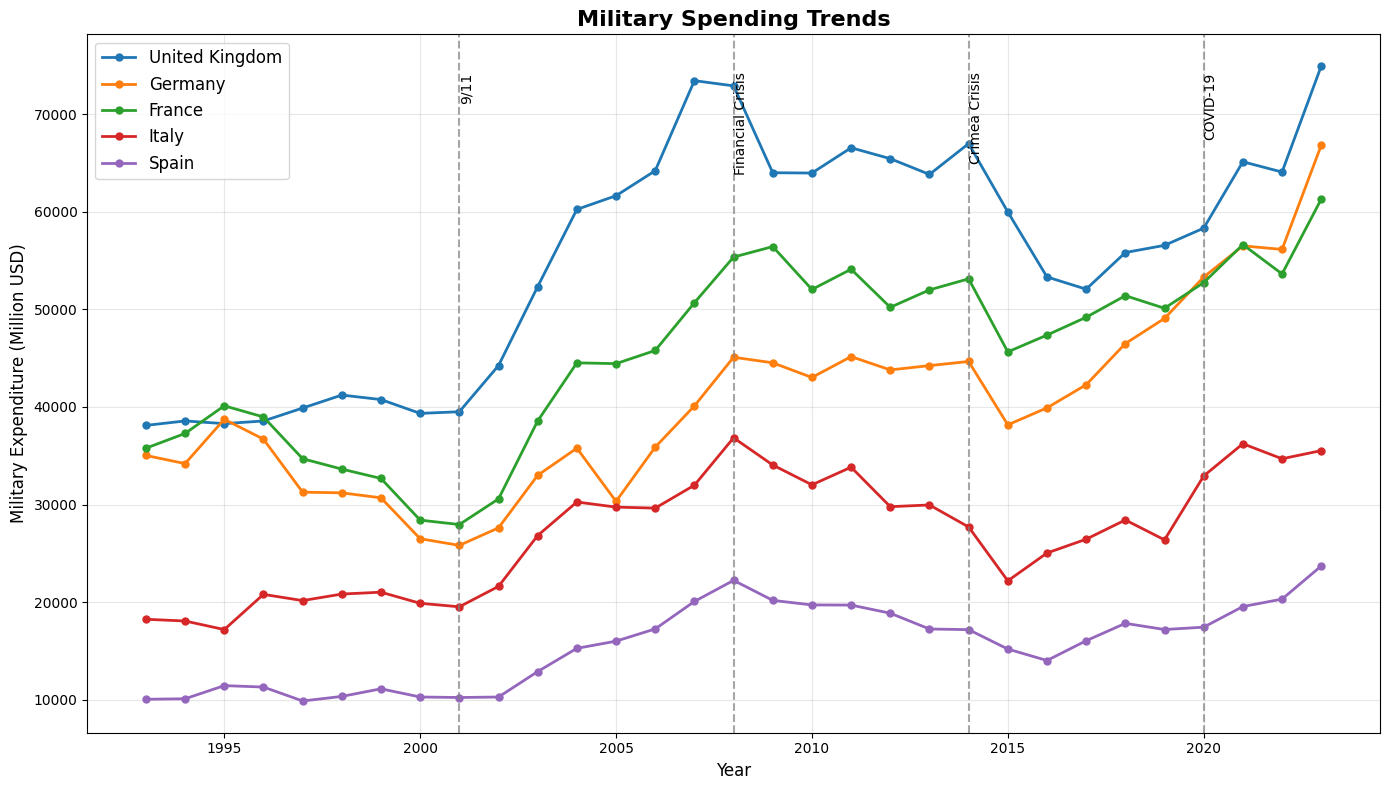

In [13]:
# Cell 12: Step 6A - Spending Trends Visualization
# Run this cell to visualize spending trends
if 'df' in locals() and df is not None:
    print("\nVisualization 1: Military Spending Trends (1993-2023)")
    plot_spending_trends(df)
else:
    print("⚠️ Please run the previous cells to process data first.")


Visualization 2: Current Military Spending Ranking


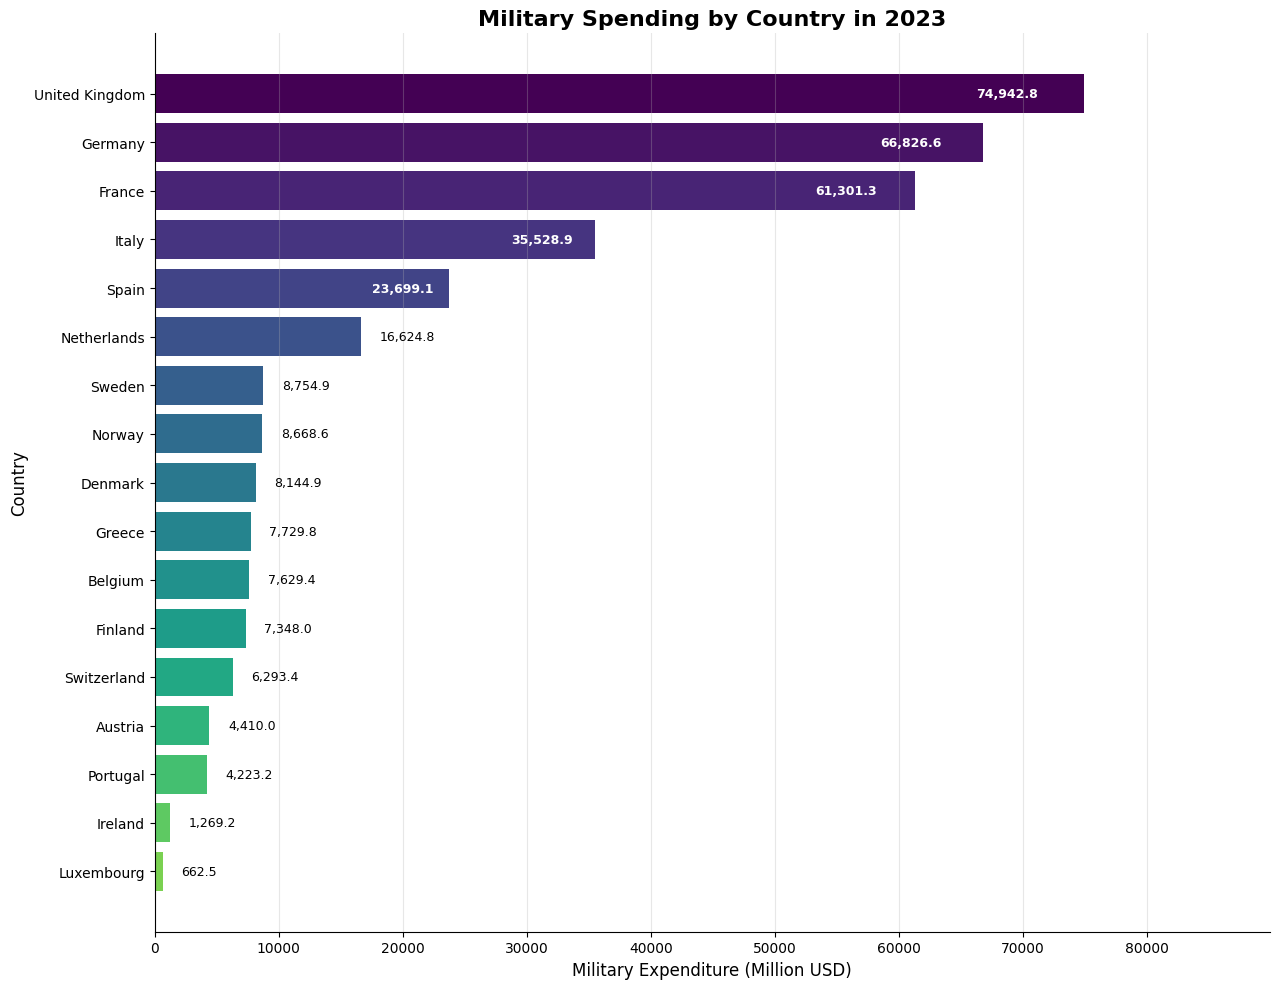

In [14]:
# Cell 13: Step 6B - Current Spending Visualization
# Run this cell to visualize current spending ranking
if 'df' in locals() and df is not None:
    print("\nVisualization 2: Current Military Spending Ranking")
    plot_current_spending(df)
else:
    print("⚠️ Please run the previous cells to process data first.")


Visualization 3: Military Spending Year-over-Year % Change Heatmap


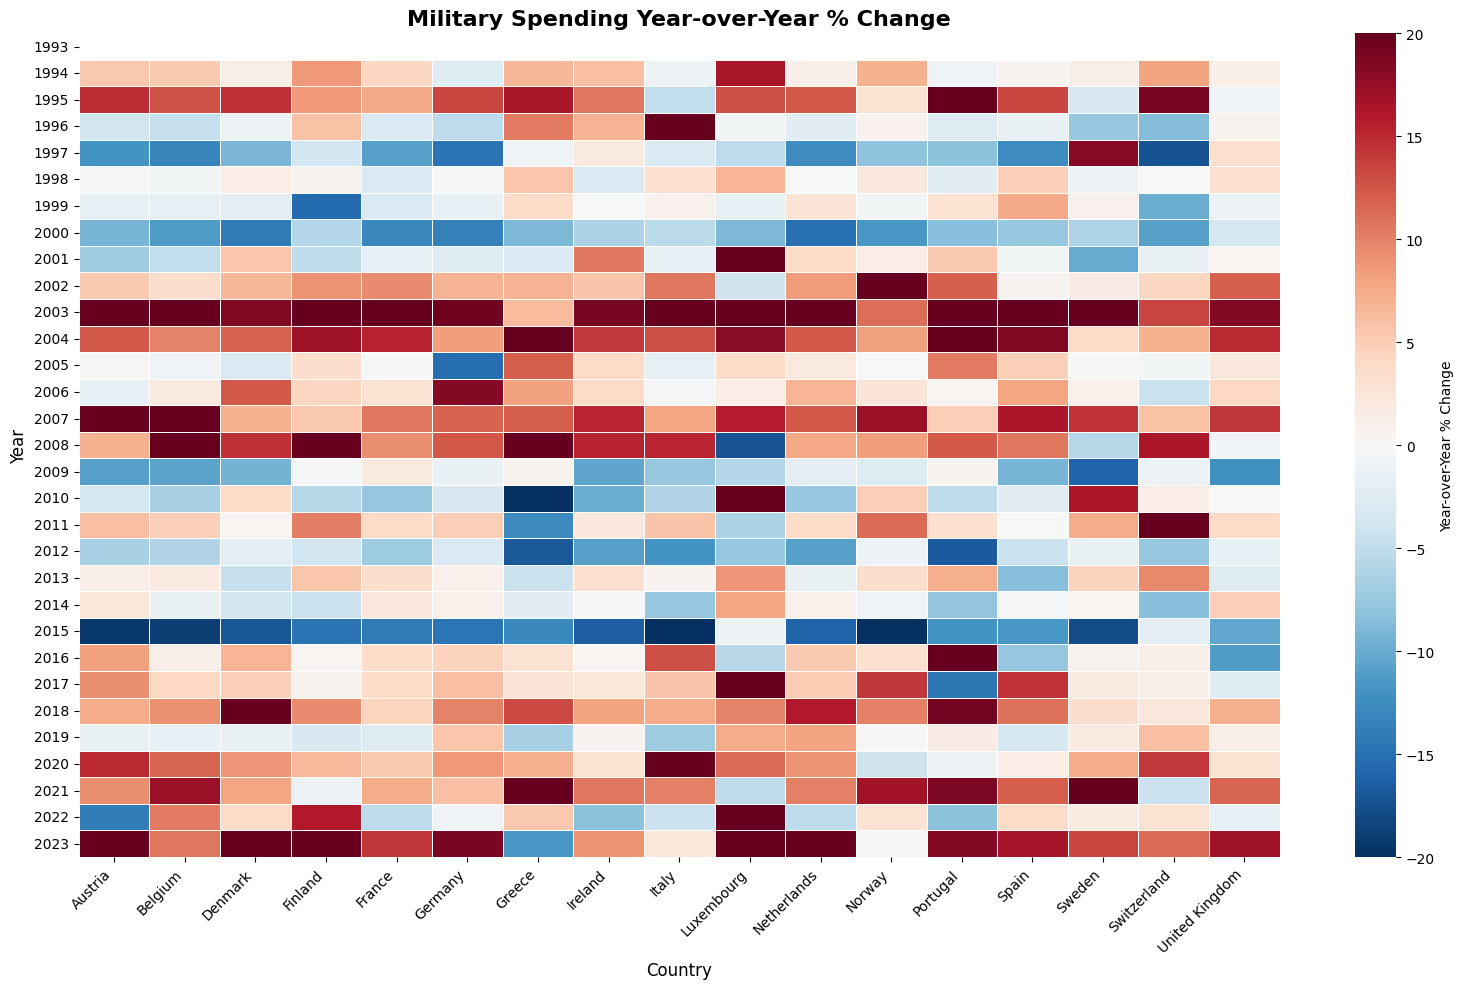

In [15]:
# Cell 14: Step 6C - Spending Heatmap Visualization
# Run this cell to visualize the heatmap
if 'df' in locals() and df is not None:
    print("\nVisualization 3: Military Spending Year-over-Year % Change Heatmap")
    plot_spending_heatmap(df)
else:
    print("⚠️ Please run the previous cells to process data first.")

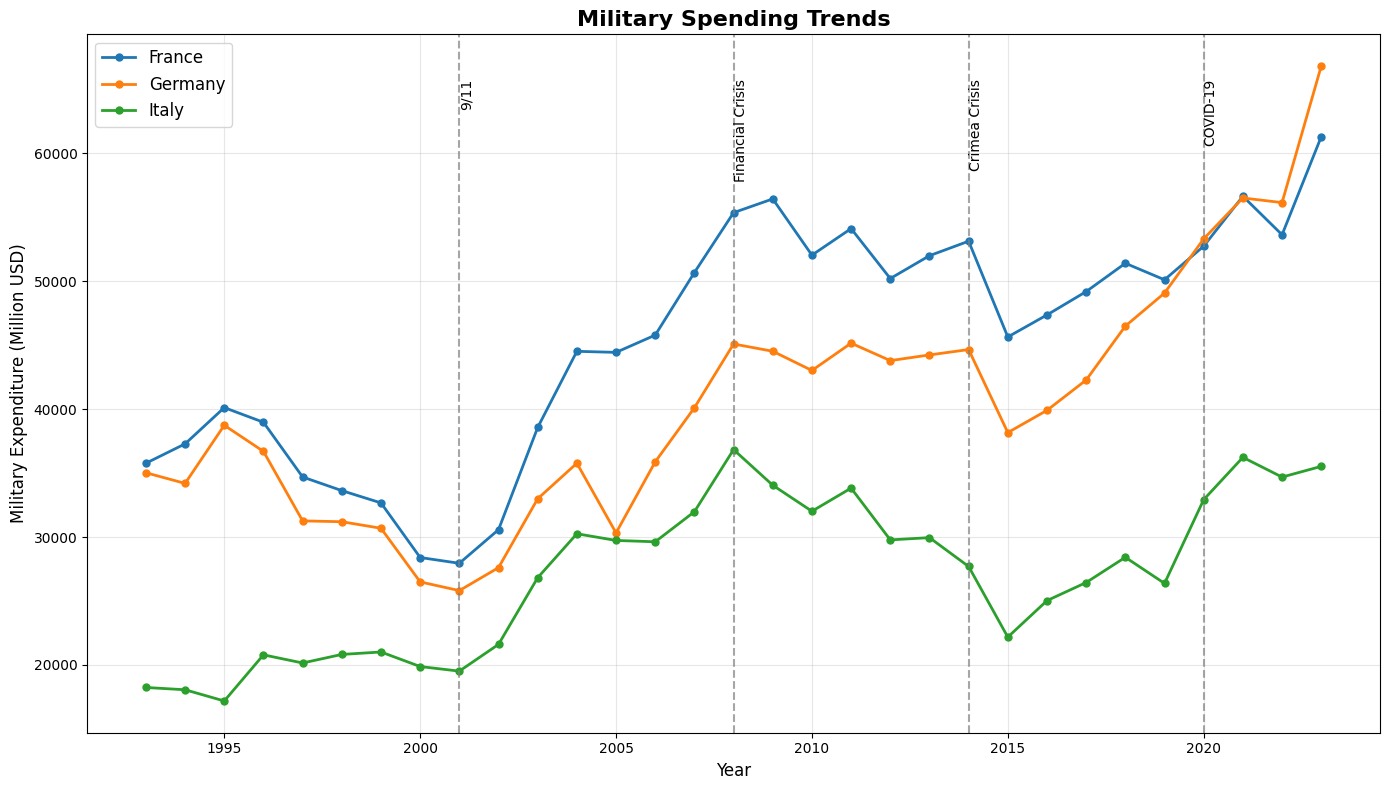

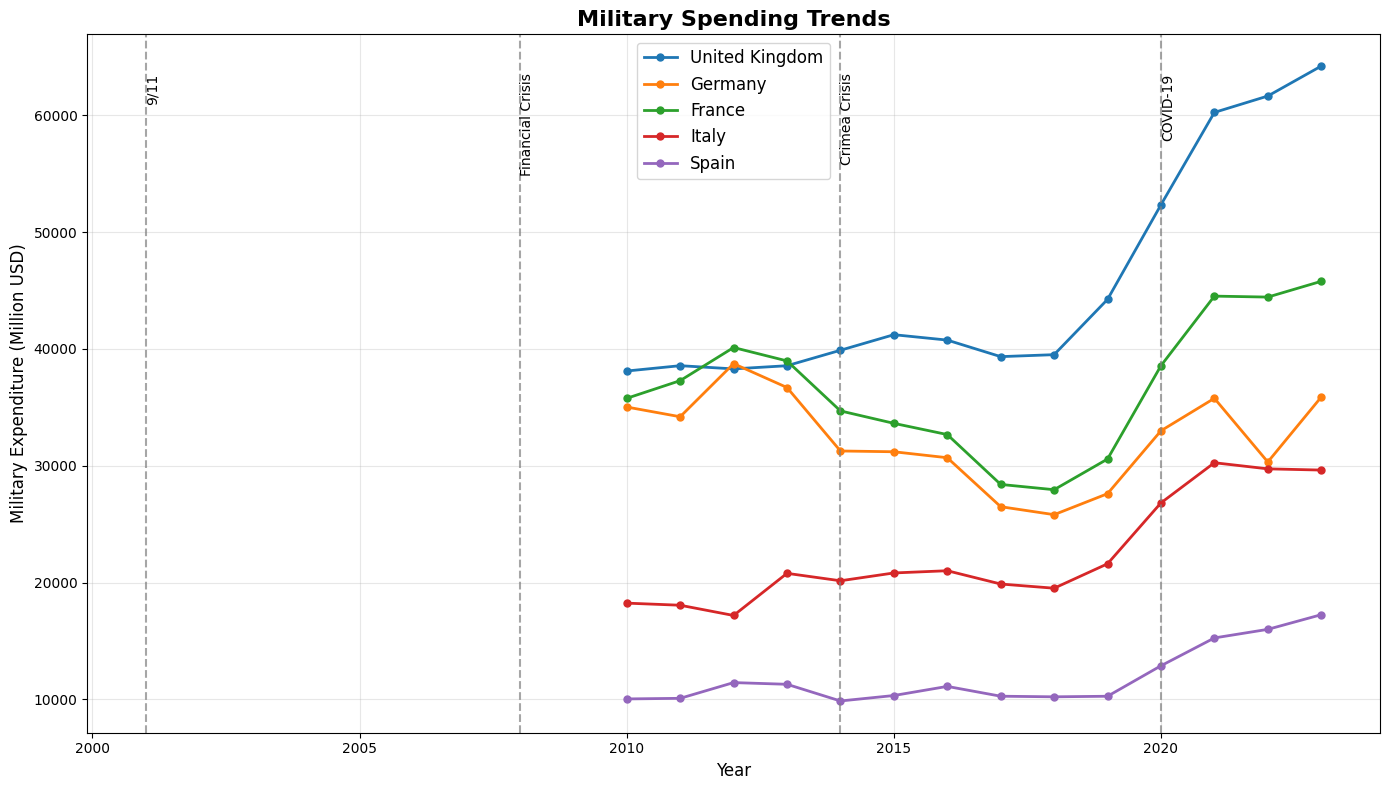

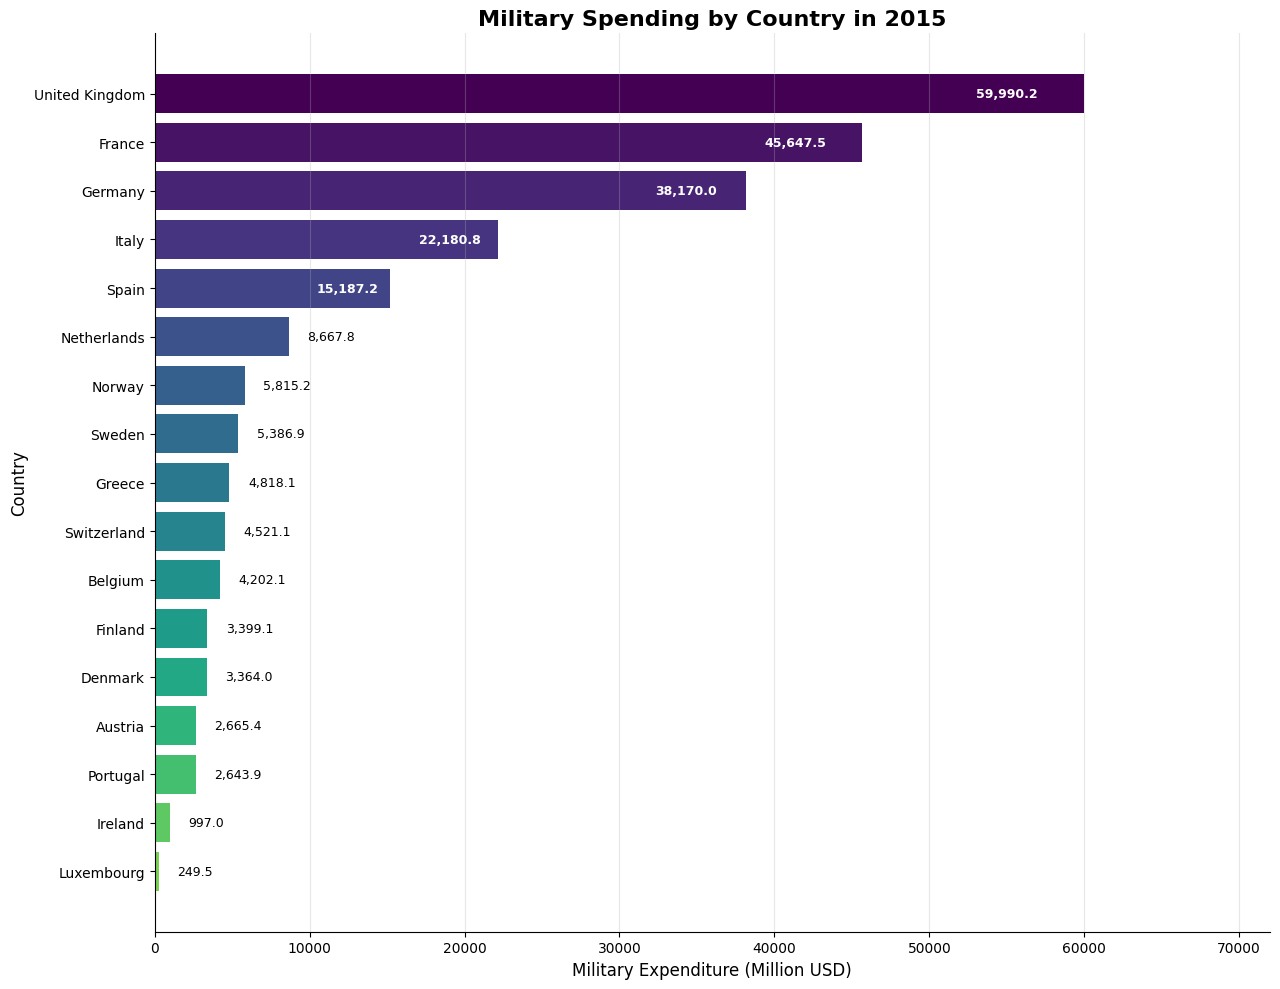


✅ Analysis completed!


In [16]:
# Cell 15: Custom Analysis

# Example 1: Compare specific countries
countries_to_compare = ["France", "Germany", "Italy"]
plot_spending_trends(df, selected_countries=countries_to_compare)

# Example 2: Focus on a specific time period
plot_spending_trends(df, year_range=(2010, 2023))

# Example 3: Analyze a specific year
plot_current_spending(df, year=2015)

print("\n✅ Analysis completed!")